In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


### Create dataset

In [2]:
samples = 1500
X, Y = make_circles(samples, noise = 0.04)

In [3]:
X.shape, Y.shape

((1500, 2), (1500,))

In [4]:
# convert to pandas dataframe
df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'Label': Y})

In [5]:
df.head()

,X1,X2,Label
0,-0.609547,-0.533343,1
1,-0.936642,0.293821,0
2,0.949989,-0.160482,0
3,-0.849952,-0.557364,0
4,0.078331,-0.784731,1


In [6]:
# check the distribution of labels
df.Label.value_counts()

Label
1    750
0    750
Name: count, dtype: int64

Nicely balanced dataset, no rare labels.

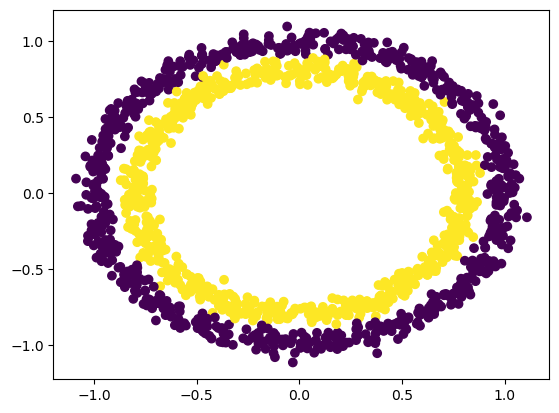

In [7]:
plt.scatter(x = df['X1'], y = df['X2'], c = df["Label"])

In [8]:
type(X)

numpy.ndarray

In [9]:
# convert to torch tensors
X = torch.from_numpy(X).type(torch.FloatTensor)
Y = torch.from_numpy(Y).type(torch.FloatTensor)

In [10]:
type(X), type(Y)

(torch.Tensor, torch.Tensor)

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y,
                                                    test_size=.20,
                                                    random_state=42)

In [12]:
train_X[:5], train_Y[:5]

(tensor([[ 0.0317, -0.7556],
         [-0.6024,  0.5510],
         [-0.4346,  0.7368],
         [-0.5900,  0.7270],
         [ 0.7268, -0.6780]]),
 tensor([1., 1., 1., 0., 0.]))

### Build the model

In [13]:
class CircularLinNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features= 6)
        self.layer_2 = nn.Linear(in_features=6, out_features=1)

    def forward(self, X):
        return self.layer_2(self.layer_1(X))
    
# create instance and load on device
model_C = CircularLinNN().to(device)
model_C.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.5925, -0.6706],
                      [-0.5366, -0.0850],
                      [ 0.5818,  0.1565],
                      [ 0.2644,  0.0139],
                      [ 0.5099, -0.5976],
                      [-0.4814, -0.2583]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.1968,  0.0543, -0.5834, -0.1146, -0.5559,  0.0081], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2643,  0.2643,  0.1905, -0.2059, -0.1858, -0.1784]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([0.2573], device='cuda:0'))])

In [14]:
# alternative way of instatiating model
model_seq = nn.Sequential(
    nn.Linear(in_features=2,out_features=6),
    nn.Linear(in_features=6, out_features=1)
).to(device)

In [15]:
model_seq.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0180, -0.2590],
                      [-0.4685,  0.0738],
                      [-0.4388,  0.2433],
                      [ 0.1544, -0.2777],
                      [ 0.0757, -0.5055],
                      [ 0.6510,  0.1345]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6994, -0.1568, -0.3026, -0.1328, -0.4912, -0.5507], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2854, -0.3688,  0.3493, -0.0340,  0.2034,  0.3619]],
                     device='cuda:0')),
             ('1.bias', tensor([-0.0133], device='cuda:0'))])

So we get similar outcomes but the first approach is a lot more customizable

### Make preds with untrained model

In [16]:
with torch.inference_mode():
    pred_Y = model_C(test_X.to(device))     # never forget to send to the device

In [17]:
len(pred_Y), len(test_Y)

(300, 300)

In [18]:
pred_Y[:5], test_Y[:5]

(tensor([[0.2718],
         [0.2351],
         [0.5679],
         [0.1287],
         [0.1002]], device='cuda:0'),
 tensor([1., 0., 0., 1., 0.]))

Completely wrong outcomes!!

### Training the model

In [44]:
loss_func = nn.BCEWithLogitsLoss()    # BCE + Sigmoid
opti = torch.optim.SGD(params= model_C.parameters(), lr=.01)

# evaluation metrics

def accuracy_func(y_label, y_pred):
    # how many of the preds are correct
    # .item() → convert tensor scalar to Python number
    return (torch.eq(y_label, y_pred).sum().item()  / len(y_pred)) * 100

In [45]:
model_C.eval()
with torch.inference_mode():
    # raw logit -> out from linear transformation
    y = model_C(test_X.to(device))
    # convert to probs
    y = torch.round(torch.sigmoid(y)).squeeze()
len(y)

300

In [46]:
len(test_Y)

300

In [51]:
epochs = 200

# Put data to target device
# must do this step !!
train_X, train_Y = train_X.to(device), train_Y.to(device)
test_X, test_Y = test_X.to(device), test_Y.to(device)


for epoch in range(epochs):

    model_C.train()
    # 1. forward
    train_logit = model_C(train_X).squeeze()
    train_pred_Y = torch.round(torch.sigmoid(train_logit))

    # 2. calculate loss and accuracy
    train_loss = loss_func(train_logit, train_Y)
    accuracy = accuracy_func(train_Y, pred_Y)

    # 3. set optimizer grad to 0
    opti.zero_grad()

    # 4. backprop
    train_loss.backward()

    # 5. optimizer step
    opti.step()

    model_C.eval()
    with torch.inference_mode():
        test_logit = model_C(test_X).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logit))

        test_loss = loss_func(test_logit, test_Y)
        test_accuracy = accuracy_func(test_Y, test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")

        
    

Epoch: 0 | Loss: 0.69399, Accuracy: 49.75% | Test loss: 0.69251, Test acc: 59.67%
Epoch: 10 | Loss: 0.69391, Accuracy: 49.75% | Test loss: 0.69251, Test acc: 58.00%
Epoch: 20 | Loss: 0.69384, Accuracy: 49.75% | Test loss: 0.69252, Test acc: 57.00%
Epoch: 30 | Loss: 0.69377, Accuracy: 49.75% | Test loss: 0.69253, Test acc: 56.00%
Epoch: 40 | Loss: 0.69371, Accuracy: 49.75% | Test loss: 0.69254, Test acc: 55.00%
Epoch: 50 | Loss: 0.69366, Accuracy: 49.75% | Test loss: 0.69256, Test acc: 56.00%
Epoch: 60 | Loss: 0.69361, Accuracy: 49.75% | Test loss: 0.69257, Test acc: 55.33%
Epoch: 70 | Loss: 0.69357, Accuracy: 49.75% | Test loss: 0.69259, Test acc: 56.00%
Epoch: 80 | Loss: 0.69353, Accuracy: 49.75% | Test loss: 0.69261, Test acc: 55.33%
Epoch: 90 | Loss: 0.69349, Accuracy: 49.75% | Test loss: 0.69263, Test acc: 55.67%
Epoch: 100 | Loss: 0.69346, Accuracy: 49.75% | Test loss: 0.69265, Test acc: 55.67%
Epoch: 110 | Loss: 0.69343, Accuracy: 49.75% | Test loss: 0.69268, Test acc: 55.33%
Epo

Without non linearity, the results are not really acceptable. Its as good as randomly guessing